## Movie Recommendation using Collaborative Filtering
User-User Filtering.

It uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the Pearson Correlation Function.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt

### Movies

In [2]:
movie_df = pd.read_csv('movies.csv')
movie_df = movie_df.drop(['genre','movie_logo'],axis=1)
movie_df.head()

,id,title
0,18,12 Angry Men
1,19,12 Years a Slave
2,20,A Beautiful Mind
3,21,Avatar
4,22,Avengers: Infinity War


### All Rating
Collaborative filtering doesn't recommend based on the features of the movie. The recommendation is based on the likes and dislikes or ratings of the neighbours or other users.
Now, coming to the ratings dataframe, we have the movieId column that is common with the movie dataframe. Each user has given multiple ratings for different movies.

In [3]:
all_rating_df = pd.read_csv('movie_rating.csv')
all_rating_df = all_rating_df.drop(['id'],axis=1)
all_rating_df.head()

,user_id,movie_id,rating
0,14,21,5
1,15,21,3
2,15,34,3
3,15,23,5
4,14,23,2


The technique is called Collaborative Filtering, which is also known as User-User Filtering. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the Pearson Correlation Function.

The process for creating a User Based recommendation system is as follows:

- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score

### My Rating Movie

In [4]:
my_rating_df = pd.read_csv('Myrating.csv')
my_rating_df = my_rating_df.drop(['id'],axis=1)
my_rating_df.head()

,user_id,movie_id,rating
0,14,21,5
1,14,23,2


We need to now add the movieId column from the movie dataframe into the inputMovie Dataframe. First filter out the rows that contain the input movies' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [5]:
#Filtering out the movies by title
merge_df = movie_df[movie_df['id'].isin(my_rating_df['movie_id'].tolist())]

#Then merging it so we can get the movieId. It's implicitly merging it by title.
myRating = my_rating_df.merge(movie_df,left_on='movie_id', right_on='id').drop(['id'],axis=1)
myRating

,user_id,movie_id,rating,title
0,14,21,5,Avatar
1,14,23,2,Avengers: Endgame


Finding the users who have seen the same movies from the rating dataframe With the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.

In [6]:
#Filtering out users that have watched movies that the input has watched and storing it
filter_users = all_rating_df[all_rating_df['movie_id'].isin(myRating['movie_id'].tolist())]
filter_users.head()

,user_id,movie_id,rating
0,14,21,5
1,15,21,3
3,15,23,5
4,14,23,2


In [7]:
filter_users.shape

(4, 3)

In [8]:
# Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = filter_users.groupby(['user_id'])

In [9]:
#showing one such group example by getting all the users of a particular uderId
userSubsetGroup.get_group(14) # user_id 14 is yi.panharith

,user_id,movie_id,rating
0,14,21,5
4,14,23,2


In [10]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

C:\Users\khaing\AppData\Local\Temp\ipykernel_4680\1348096693.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)


In [11]:
userSubsetGroup[0:3]

[(14,
     user_id  movie_id  rating
  0       14        21       5
  4       14        23       2),
 (15,
     user_id  movie_id  rating
  1       15        21       3
  3       15        23       5)]

Similarity of users to input user Next, we are going to compare all users to our specified user and find the one that is most similar. we're going to find out how similar each user is to the input through the Pearson Correlation Coefficient. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

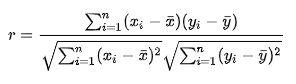

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation.

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

In [12]:
userSubsetGroup = userSubsetGroup[0:100]

In [13]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movie_id')
    myRating = myRating.sort_values(by='movie_id')
    
    #Get the N for the formula
    n = len(group)
    #Get the review scores for the movies that they both have in common
    temp = myRating[myRating['movie_id'].isin(group['movie_id'].tolist())]
    
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp['rating'].tolist()
    
    #put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(n)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(n)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorDict[name] = 0

In [14]:
pearsonCorDict.items()

dict_items([(14, 1.0), (15, -1.0)])

In [15]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['user_id'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,user_id
0,1.0,14
1,-1.0,15


In [16]:
topUsers = pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,user_id
0,1.0,14
1,-1.0,15


Rating of selected users to all movies We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our pearsonDF from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

### Top User Rating

In [17]:
topUsersRating = topUsers.merge(all_rating_df, left_on='user_id', right_on='user_id', how='inner')
topUsersRating.head()

,similarityIndex,user_id,movie_id,rating
0,1.0,14,21,5
1,1.0,14,23,2
2,-1.0,15,21,3
3,-1.0,15,34,3
4,-1.0,15,23,5


multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

In [18]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex'] * topUsersRating['rating']
topUsersRating.head()

,similarityIndex,user_id,movie_id,rating,weightedRating
0,1.0,14,21,5,5.0
1,1.0,14,23,2,2.0
2,-1.0,15,21,3,-3.0
3,-1.0,15,34,3,-3.0
4,-1.0,15,23,5,-5.0


In [19]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movie_id').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movie_id,,
21,0.0,2.0
23,0.0,-3.0
34,-1.0,-3.0


In [20]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()

#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movie_id'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movie_id
movie_id,,
21,inf,21
23,-inf,23
34,3.0,34


In [21]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movie_id
movie_id,,
21,inf,21
34,3.0,34
23,-inf,23


In [22]:
movie_df.loc[movie_df['id'].isin(recommendation_df.head(10)['movie_id'].tolist())]

,id,title
3,21,Avatar
5,23,Avengers: Endgame
16,34,Frozen
